# ファイルの入出力

Polarsでは、大規模なデータセットを効率的に扱うための高速なファイル入出力操作が提供されています。データを読み込んだり書き出したりする際に、さまざまなフォーマットに対応しており、迅速なデータ処理をサポートします。この章では、Polarsを使用したファイルの入出力操作方法について詳しく説明します。

In [1]:
import polars as pl
from helper.jupyter import row, capture_except

## CSVファイル

CSVファイルを読み込む際には、ファイル構造やデータの特性に応じて柔軟に操作する必要があります。本セクションでは、Polarsを使用してさまざまなCSVファイルを読み込む方法を紹介します。

### 読み込み

#### ヘッダー

CSVファイルには、ヘッダーの有無や、ヘッダーが複数行にわたる場合があります。以下のデータを例に、ヘッダーの扱い方について説明します。

In [2]:
%%writefile data/csv_header.csv
A,B
a,b
0,1
2,3
4,5

Overwriting data/csv_header.csv


- `df1`: デフォルト設定では、CSVファイルをヘッダー付きとして読み込みます。この場合、データの先頭行が列の名前として解釈されます。
- `df2`: `has_header=False`を指定することで、CSVの先頭行をデータとして扱います。この場合、`new_columns`引数を使用して列名を自分で指定できます。
- `df3`: `skip_rows`引数を指定することで、最初のN行をスキップしてからデータを読み込むことができます。
- `df4`: `skip_rows_after_header`引数を指定することで、ヘッダー行の次のN行をスキップしてデータを読み込みます。
- `df5`: 最初の2行をヘッダーなしで読み込んで、それぞれの列を結合した結果を`new_columns`引数に渡し、新しい列名として適用します。この方法を使うことで、複数行のヘッダーを柔軟に扱うことができます。

これらの方法を活用することで、CSVデータの構造に応じた柔軟な読み込みが可能になります。

In [3]:
fn = 'data/csv_header.csv'
df1 = pl.read_csv(fn)
df2 = pl.read_csv(fn, has_header=False, new_columns=['x', 'y'])
df3 = pl.read_csv(fn, skip_rows=1)
df4 = pl.read_csv(fn, skip_rows_after_header=1)

df_header = pl.read_csv(fn, n_rows=2, has_header=False)
columns = df_header.select(pl.all().str.join('-')).row(0)
df5 = pl.read_csv(fn, has_header=False, skip_rows=2, new_columns=columns)
row(df1, df2, df3, df4, df5)

A,B
str,str
"""a""","""b"""
"""0""","""1"""
"""2""","""3"""
"""4""","""5"""
x,y
str,str
"""A""","""B"""
"""a""","""b"""
"""0""","""1"""


#### 列のデータ型

`infer_schema`引数がデフォルト値`True`の場合、`infer_schema_length`引数で指定された先頭の行数を使用して各列のデータ型を推定します。この範囲を超えて異なるデータ型の値が出現した場合、エラーが発生します。以下のデータを例に、データ型の扱い方について説明します。

In [4]:
%%writefile data/csv_different_type.csv
A,B
0,1
2,3
4,5
a,5.5
10,20

Overwriting data/csv_different_type.csv


`infer_schema_length`のデフォルト値は100ですが、以下のコードでは、`infer_schema_length`を2行に設定してエラーを発生させます。

In [5]:
%%capture_except
df = pl.read_csv('data/csv_different_type.csv', infer_schema_length=2)

ComputeError: could not parse `a` as dtype `i64` at column 'A' (column number 1)

The current offset in the file is 15 bytes.

You might want to try:
- increasing `infer_schema_length` (e.g. `infer_schema_length=10000`),
- specifying correct dtype with the `schema_overrides` argument
- setting `ignore_errors` to `True`,
- adding `a` to the `null_values` list.

Original error: ```remaining bytes non-empty```


エラーメッセージにはいくつかの解決方法が示されています。以下はそれらの方法を使用してデータを読み込む例です。

- **`df1`**: `infer_schema_length`引数で推定行数を増やすことで、A列のデータ型を`str`、B列を`f64`として読み込みます。

- **`df2`**: `infer_schema_length=None`を指定すると、すべての行を使用してデータ型を推定します。また、`null_values`引数を使用して特定の値をnullと見なすことで、A列を`i64`として読み込みます。

- **`df3`**: `ignore_errors=True`を指定すると、推定データ型に一致しない値をnullとして読み込みます。この場合、A列とB列はどちらも`i64`になります。

- **`df4`**: `schema_overrides`引数を使用して、各列のデータ型を明示的に指定します。さらに、`ignore_errors=True`を指定して不正な値を除外します。`schema_overrides`を使用すると、効率的なデータ型を選択でき、メモリ使用量を削減できます。

これらの方法を使用することで、データ型の推定やエラー処理に柔軟に対応できます。

In [6]:
fn = 'data/csv_different_type.csv'
df1 = pl.read_csv(fn, infer_schema_length=1000)
df2 = pl.read_csv(fn, infer_schema_length=None, null_values=['a'])
df3 = pl.read_csv(fn, infer_schema_length=2, ignore_errors=True)
df4 = pl.read_csv(fn, schema_overrides={'A':pl.Int16, 'B':pl.Float32}, ignore_errors=True)
row(df1, df2, df3, df4)

A,B
str,f64
"""0""",1.0
"""2""",3.0
"""4""",5.0
"""a""",5.5
"""10""",20.0
A,B
i64,f64
0,1.0
2,3.0


#### スペース処理

CSVデータ内の列値に末尾のスペースが含まれている場合、Polarsの標準CSVエンジンはこれをそのまま取り込み、列データ型を`str`として解釈します。例えば、次のようなCSVデータを読み込む場合を考えます：

In [7]:
%%writefile data/csv_trailing_space.csv
str,int,float
日本語 ,4 ,5.67 
abc ,5 ,1.23 

Overwriting data/csv_trailing_space.csv


このデータを読み込むと、Polarsの標準エンジンと`use_pyarrow=True`を指定した場合で動作が異なります：

* `df1`: Polarsの標準エンジンでは、すべての列が文字列(`str`)として扱われます。
* `df2`: `use_pyarrow=True`を指定すると、数値列(`int`, `float`)が適切に解釈されます。

In [8]:
fn = 'data/csv_trailing_space.csv'
df1 = pl.read_csv(fn)
df2 = pl.read_csv(fn, use_pyarrow=True)
row(df1, df2)

str,int,float
str,str,str
"""日本語 ""","""4 ""","""5.67 """
"""abc ""","""5 ""","""1.23 """
str,int,float
str,i64,f64
"""日本語 """,4,5.67
"""abc """,5,1.23


Polarsでは文字列列を自動的に数値型に変換するカスタム関数を作成することで、スペースを取り除きつつ適切にキャストできます。以下はその例です。

1. `s.str.strip_chars()` を使用して余分なスペースを削除。
2. `.cast(int_type)` を試みて、整数型に変換できるかを確認。
3. 整数型への変換が失敗した場合は `.cast(float_type)` を試みて、浮動小数型に変換。
4. どちらのキャストも失敗した場合には元の文字列型を返す。

In [9]:
from polars import selectors as cs
from polars.exceptions import InvalidOperationError

# この関数はhelper/polars.pyにあります。
def try_cast_to_number(s, int_type=pl.Int64, float_type=pl.Float64):
    try:
        return s.str.strip_chars().cast(int_type)
    except InvalidOperationError:
        try:
            return s.str.strip_chars().cast(float_type)
        except InvalidOperationError:
            return s

df1.with_columns(cs.string().map_batches(try_cast_to_number))

str,int,float
str,i64,f64
"""日本語 """,4,5.67
"""abc """,5,1.23


#### 複数のファイルを読み込み

次のコードを実行して、stockデータを`data/stock`フォルダにダウンロードします。

In [10]:
from helper.utils import download_folder_from_github, print_folder_structure
download_folder_from_github("https://github.com/jeroenjanssens/python-polars-the-definitive-guide/tree/main/data/stock", "data/stock")

data/stock exists, please delete and try again.


ダウンロードしたデータのフォルダ構造は次のようなものです。

In [11]:
print_folder_structure("data/stock", max_file_count=3)

|-- asml
    |-- 1999.csv
    |-- 2000.csv
    |-- 2001.csv
    |-- ...
|-- nvda
    |-- 1999.csv
    |-- 2000.csv
    |-- 2001.csv
    |-- ...
|-- tsm
    |-- 1999.csv
    |-- 2000.csv
    |-- 2001.csv
    |-- ...


上のすべてのCSVファイルを一気に読み込みするのは、ファイルパスにワイルドカードを使用します。

In [12]:
df_stock = pl.read_csv('data/stock/**/*.csv', try_parse_dates=True)
df_stock

symbol,date,open,high,low,close,adj close,volume
str,str,f64,f64,f64,f64,f64,i64
"""ASML""","""1999-01-04""",11.765625,12.28125,11.765625,12.140625,7.522523,1801867
"""ASML""","""1999-01-05""",11.859375,14.25,11.71875,13.96875,8.655257,8241600
"""ASML""","""1999-01-06""",14.25,17.601563,14.203125,16.875,10.456018,16400267
"""ASML""","""1999-01-07""",14.742188,17.8125,14.53125,16.851563,10.441495,17722133
"""ASML""","""1999-01-08""",16.078125,16.289063,15.023438,15.796875,9.787995,10696000
…,…,…,…,…,…,…,…
"""TSM""","""2023-06-26""",102.019997,103.040001,100.089996,100.110001,99.125954,8560000
"""TSM""","""2023-06-27""",101.150002,102.790001,100.019997,102.080002,101.076591,9732000
"""TSM""","""2023-06-28""",100.5,101.879997,100.220001,100.919998,99.927986,8160900


この例では各個CSVファイル中のデータにはファイル名の情報が含まれているため、ファイル名を列として作成する必要がないですが、ファイル名を結果に追加したい場合は、`include_file_paths`引数を使います。ファイル名列の名前はこの引数で指定された列名になります。`read_csv()`はまだこの引数をサポートしていないため、次の例では遅延演算の`scan_csv()`関数を使います。この関数のリターン値は`LazyFrame`で、`collect()`メソッドを使って実際のデータを読み出します。

In [13]:
df_stock = pl.scan_csv('data/stock/**/*.csv', try_parse_dates=True, include_file_paths="path")
df_stock

In [14]:
df_stock.collect()

symbol,date,open,high,low,close,adj close,volume,path
str,date,f64,f64,f64,f64,f64,i64,str
"""ASML""",1999-01-04,11.765625,12.28125,11.765625,12.140625,7.522523,1801867,"""data\stock\asml\1999.csv"""
"""ASML""",1999-01-05,11.859375,14.25,11.71875,13.96875,8.655257,8241600,"""data\stock\asml\1999.csv"""
"""ASML""",1999-01-06,14.25,17.601563,14.203125,16.875,10.456018,16400267,"""data\stock\asml\1999.csv"""
"""ASML""",1999-01-07,14.742188,17.8125,14.53125,16.851563,10.441495,17722133,"""data\stock\asml\1999.csv"""
"""ASML""",1999-01-08,16.078125,16.289063,15.023438,15.796875,9.787995,10696000,"""data\stock\asml\1999.csv"""
…,…,…,…,…,…,…,…,…
"""TSM""",2023-06-26,102.019997,103.040001,100.089996,100.110001,99.125954,8560000,"""data\stock\tsm\2023.csv"""
"""TSM""",2023-06-27,101.150002,102.790001,100.019997,102.080002,101.076591,9732000,"""data\stock\tsm\2023.csv"""
"""TSM""",2023-06-28,100.5,101.879997,100.220001,100.919998,99.927986,8160900,"""data\stock\tsm\2023.csv"""


#### 行ベーステキストファイルの解析

テキストファイルがCSV形式でない場合でも、ファイルのすべての行を一つの列として読み込むことで、Polarsの強力な処理能力を活用して必要な情報を抽出し、一つのデータフレームにまとめることができます。次の `variables_dump.txt` ファイルの各行には、変数の値と変数名のダンプが記録されています。

In [2]:
%%writefile data/variables_dump.txt
A = 1, B = 2, C = 3.23
A = 11, B = 22, C = 33.23
B = 30, C = 20.0
D = 10, A = 3

Writing data/variables_dump.txt


次のプログラムは、上記の形式のファイルを解析するものです。`read_csv()` を使ってファイルを読み込む際に、区切り文字 `separator` に通常のテキスト中では現れない文字 `"\x00"`（ヌル文字）を指定することで、ファイルの各行をまるごと 1 列として読み込むことができます。

その後、以下の演算やメソッドを使って、各行の文字列を解析します。

* `.str.split(",")`：行内の各変数を `,` で分割します。
* `.explode("s")`：分割されたリストを縦に展開し、それぞれを個別の行にします。
* `.str.extract_groups(...)`：正規表現を用いて、変数名（`name`）と値（`value`）を抽出します。
* `.pivot(...)`：変数名を列名として整形し、各行を 1 サンプルとして再構成します。
* `.cast(pl.Float64)`：値を `Float64` 型に変換します。

最後に、各列について小数点以下が常に 0（すなわち実質的に整数）である列を検出し、それらを `Int64` 型にキャストします。

In [5]:
df = pl.read_csv(
    'data/variables_dump.txt', has_header=False, separator="\x00", new_columns=["s"]
)

df_vars = (
    df.select(pl.col("s").str.split(","))
    .with_row_index()
    .explode("s")
    .with_columns(
        pl.col("s").str.extract_groups(r"(?<name>\w)+\s*=\s*(?<value>.+)")
    )
    .unnest("s")
    .pivot(on="name", index="index")
    .with_columns(pl.exclude("index").cast(pl.Float64))
)

int_cols = (
    df2.select((pl.col(pl.Float64) % 1 == 0).all())
    .transpose(include_header=True)
    .filter("column_0")
    .get_column("column")
    .to_list()
)

df_vars = df_vars.with_columns(pl.col(int_cols).cast(pl.Int64))
row(df, df_vars)

shape: (4, 1) s str "A = 1, B = 2, C = 3.23" "A = 11, B = 22, C = 33.23" "B = 30, C = 20.0" "D = 10, A = 3" 
 shape: (4, 5) index A B C D u32 i64 i64 f64 i64 0 1 2 3.23 null 1 11 22 33.23 null 2 null 30 20.0 null 3 3 null null 10

### 書き出し

`DataFrame.write_csv()` を使用して、データフレームをCSVファイルとして出力できます。

In [33]:
df1.write_csv('data/csv_output_utf8.csv')

`write_csv()`メソッドでは、`include_header`、`separator`、`line_terminator` などの引数を使って、CSVのフォーマットを細かく指定できます。ただし、エンコードを直接指定する引数はありません。そのため、一度CSVデータを `StringIO` に出力し、それを使用してSHIFT-JISエンコードのファイルとして保存する方法を取ります。以下はそのコード例です：

In [34]:
import io

buf = io.StringIO()
df1.write_csv(buf)

with open('data/csv_output_shiftjis.csv', 'w', encoding='shift-jis') as f:
    f.write(buf.getvalue())

## Excelファイル

`read_excel()`と`DataFrame.write_excel()`を使用してExcelファイルの入出力を行います。Excelファイルの読み込みには、`calamine`、`xlsx2csv`、`openpyxl`の3つのエンジンが利用可能で、デフォルトの`calamine`は最も高速です。書き出しには`xlsxwriter`ライブラリを使用します。次のコマンドで必要なライブラリをインストールします。

```
conda install fastexcel xlsxwriter
```

### 読み込み

次のコードは、指定されたシートからデータを読み込みます。`sheet_id`引数には、読み込みたいシート番号（1から始まる整数）或いはシート番号のリストを指定します。0の場合はすべてのシートを読み込みます。複数のシートを読み込む場合、シート名をキー、データフレームを値とする辞書を返します。`sheet_names`引数を使用して、シート名で読み込み対象のシートを指定することもできます。

In [59]:
fn = 'data/xlsx_example.xlsx'
df1, df2 = pl.read_excel(fn, sheet_id=[1, 2]).values()
row(df1, df2)

shape: (3, 2) A B i64 str 1 "aa" 3 "bb" 5 "cc" 
 shape: (3, 3) x y z f64 f64 f64 1.0 1.0 3.1 1.2 2.1 4.3 3.2 4.3 5.4

In [60]:
df1, df2, df3 = pl.read_excel(fn, sheet_id=0).values()
row(df1, df2, df3)

shape: (3, 2) A B i64 str 1 "aa" 3 "bb" 5 "cc" 
 shape: (3, 3) x y z f64 f64 f64 1.0 1.0 3.1 1.2 2.1 4.3 3.2 4.3 5.4 
 shape: (4, 2) A B str str "a" "b" "0" "1" "2" "3" "4" "5"

シート`Sheet3`には2行のヘッダーがあるため、直接読み込むと、2行目のヘッダーがデータとして扱われ、すべての列のデータ型が文字列になります。この問題を解決するために、`read_options`引数を使用してExcelエンジンに渡す設定を調整できます。

以下のコードでは、1回目の`read_excel()`で`n_rows=2`と`header_row=None`を指定し、先頭の2行をデータとして読み込んで、文字列結合し列名`columns`を計算します。2回目の読み込みでは、`skip_rows=2`でヘッダーをスキップし、`column_names=columns`で列名を指定します。

In [71]:
df_header = pl.read_excel(fn, sheet_id=3, read_options=dict(n_rows=2, header_row=None))
columns = df_header.select(pl.all().str.join('-')).row(0)
df3 = pl.read_excel(fn, sheet_id=3, read_options=dict(skip_rows=2, column_names=columns))
df3

A-a,B-b
i64,i64
0,1
2,3
4,5


`calamine`エンジンを使用する場合、`read_options`に渡す引数は次のようになります。

In [63]:
from fastexcel import ExcelReader
ExcelReader.load_sheet?

Signature:
ExcelReader.load_sheet(
    self,
    idx_or_name: 'int | str',
    *,
    header_row: 'int | None' = 0,
    column_names: 'list[str] | None' = None,
    skip_rows: 'int | None' = None,
    n_rows: 'int | None' = None,
    schema_sample_rows: 'int | None' = 1000,
    dtype_coercion: "Literal['coerce', 'strict']" = 'coerce',
    use_columns: 'list[str] | list[int] | str | Callable[[ColumnInfo], bool] | None' = None,
    dtypes: 'DType | DTypeMap | None' = None,
) -> 'ExcelSheet'
Docstring:
Loads a sheet lazily by index or name.

:param idx_or_name: The index (starting at 0) or the name of the sheet to load.
:param header_row: The index of the row containing the column labels, default index is 0.
                   If `None`, the sheet does not have any column labels.
                   Any rows before the `header_row` will be automatically skipped.
:param column_names: Overrides headers found in the document.
                     If `column_names` is used, `header_row` will b

### 書き出し

`DataFrame.write_excel()`を使って、指定したファイル名とシート名にデータを書き出します。複数のデータフレームを同じファイルの別々のシートに書き出す場合、次のコードのように`Workbook`オブジェクトを作成し、そのオブジェクトに対して複数回`.write_excel()`を呼び出します。

In [73]:
import xlsxwriter

with xlsxwriter.Workbook("data/xlsx_example_output.xlsx") as wb:
    df1.write_excel(wb, "df1")
    df2.write_excel(wb, "df2")
    df3.write_excel(wb, "df3")    

## JSONファイル

JSON（JavaScript Object Notation）は、JavaScriptのオブジェクト表記法に基づくデータ記述形式です。軽量でシンプルなテキスト形式のため、人間にも読みやすく、機械による解析も容易という特徴があります。`polars.read_json()`を使うことで、JSONデータをデータフレームに変換できます。以下のコードは、`bytes`型のJSONデータをデータフレームに読み込む例です。

In [2]:
json_data1 = b'''
[
    {"color":"red","value":"#f00"},
    {"color":"green","value":"#0f0"},
    {"color":"blue","value":"#00f"}
]
'''

df = pl.read_json(json_data1)
df

color,value
str,str
"""red""","""#f00"""
"""green""","""#0f0"""
"""blue""","""#00f"""


JSONの一種に、1行ごとに1つのJSONオブジェクトを記述する NDJSON（Newline Delimited JSON）フォーマットがあります。この形式のデータは、`read_ndjson()` 関数で読み込むことができます。

In [3]:
ndjson_data = b'''
{"color":"red","value":"#f00"}
{"color":"green","value":"#0f0"}
{"color":"blue","value":"#00f"}
'''

df = pl.read_ndjson(ndjson_data)
df

color,value
str,str
"""red""","""#f00"""
"""green""","""#0f0"""
"""blue""","""#00f"""


JSONデータをデータフレームに変換する際には、次のルールに従います。

1. JSONデータは辞書のリストとして扱われます。リストの各要素がデータフレームの「行」に対応し、それぞれの辞書のキーが「列」になります。最上位が辞書である場合は、それを1要素のリストとして処理します。  
2. ネストされたリストは `List` 型に、ネストされた辞書は `Struct` 型に変換されます。

次のJSONデータを読み込むと、`id`, `type`, `name`, `ppu`, `topping` などの列を持つ、3行のデータフレームになります。このうち `topping` 列は「構造体のリスト型（`List[Struct]`）」として読み込まれます。

In [4]:
json_data2 = b'''
[
	{
		"id": "0001",
		"type": "donut",
		"name": "Cake",
		"ppu": 0.55,
		"topping":
			[
				{ "id": "5001", "type": "None" },
				{ "id": "5002", "type": "Glazed" },
				{ "id": "5005", "type": "Sugar" },
				{ "id": "5007", "type": "Powdered Sugar" },
				{ "id": "5006", "type": "Chocolate with Sprinkles" },
				{ "id": "5003", "type": "Chocolate" },
				{ "id": "5004", "type": "Maple" }
			]
	},
	{
		"id": "0002",
		"type": "donut",
		"name": "Raised",
		"ppu": 0.55,
		"topping":
			[
				{ "id": "5001", "type": "None" },
				{ "id": "5002", "type": "Glazed" },
				{ "id": "5005", "type": "Sugar" },
				{ "id": "5003", "type": "Chocolate" },
				{ "id": "5004", "type": "Maple" }
			]
	},
	{
		"id": "0003",
		"type": "donut",
		"name": "Old Fashioned",
		"ppu": 0.55,
		"topping":
			[
				{ "id": "5001", "type": "None" },
				{ "id": "5002", "type": "Glazed" },
				{ "id": "5003", "type": "Chocolate" },
				{ "id": "5004", "type": "Maple" }
			]
	}
]
'''
df = pl.read_json(json_data2)
df

id,type,name,ppu,topping
str,str,str,f64,list[struct[2]]
"""0001""","""donut""","""Cake""",0.55,"[{""5001"",""None""}, {""5002"",""Glazed""}, … {""5004"",""Maple""}]"
"""0002""","""donut""","""Raised""",0.55,"[{""5001"",""None""}, {""5002"",""Glazed""}, … {""5004"",""Maple""}]"
"""0003""","""donut""","""Old Fashioned""",0.55,"[{""5001"",""None""}, {""5002"",""Glazed""}, … {""5004"",""Maple""}]"


topping列のデータ型は以下のようになります。

In [5]:
print(df.schema['topping'])

List(Struct({'id': String, 'type': String}))


ネストされた列の処理が難しい場合は、以下のように、`explode()` を使ってリストの要素を行に展開し、`struct.unnest()` を使って構造体のフィールドを列に展開することができます。

In [6]:
df.explode('topping').select(
    pl.exclude('topping'),
    pl.col('topping').struct.unnest().name.prefix('topping_')
)

id,type,name,ppu,topping_id,topping_type
str,str,str,f64,str,str
"""0001""","""donut""","""Cake""",0.55,"""5001""","""None"""
"""0001""","""donut""","""Cake""",0.55,"""5002""","""Glazed"""
"""0001""","""donut""","""Cake""",0.55,"""5005""","""Sugar"""
"""0001""","""donut""","""Cake""",0.55,"""5007""","""Powdered Sugar"""
"""0001""","""donut""","""Cake""",0.55,"""5006""","""Chocolate with Sprinkles"""
…,…,…,…,…,…
"""0002""","""donut""","""Raised""",0.55,"""5004""","""Maple"""
"""0003""","""donut""","""Old Fashioned""",0.55,"""5001""","""None"""
"""0003""","""donut""","""Old Fashioned""",0.55,"""5002""","""Glazed"""


また、元のデータフレームを次の3つのデータフレームに分割して処理するのも一つの方法です。

In [7]:
df_topping = (
    df.select(
        pl.col('topping').explode().unique().struct.unnest().name.prefix(f'topping_')
    )
    .sort(by=f'topping_id')
)

df_donut = df.drop('topping')
df_donut_topping = (
    df.select(
        'id', 
        topping_id = pl.col('topping').list.eval(
            pl.element().struct.field('id')
        )
    )
    .explode(f'topping_id')
)

row(df_donut, df_donut_topping, df_topping)

shape: (3, 4) id type name ppu str str str f64 "0001" "donut" "Cake" 0.55 "0002" "donut" "Raised" 0.55 "0003" "donut" "Old Fashioned" 0.55 
 shape: (16, 2) id topping_id str str "0001" "5001" "0001" "5002" "0001" "5005" "0001" "5007" "0001" "5006" … … "0002" "5004" "0003" "5001" "0003" "5002" "0003" "5003" "0003" "5004" 
 shape: (7, 2) topping_id topping_type str str "5001" "None" "5002" "Glazed" "5003" "Chocolate" "5004" "Maple" "5005" "Sugar" "5006" "Chocolate with Sprinkles" "5007" "Powdered Sugar"

3つのデータフレームは、`DataFrame.join()` メソッドを使って1つのデータフレームに結合できます。

In [8]:
df_donut.join(df_donut_topping, on='id').join(df_topping, on='topping_id')

id,type,name,ppu,topping_id,topping_type
str,str,str,f64,str,str
"""0001""","""donut""","""Cake""",0.55,"""5001""","""None"""
"""0001""","""donut""","""Cake""",0.55,"""5002""","""Glazed"""
"""0001""","""donut""","""Cake""",0.55,"""5005""","""Sugar"""
"""0001""","""donut""","""Cake""",0.55,"""5007""","""Powdered Sugar"""
"""0001""","""donut""","""Cake""",0.55,"""5006""","""Chocolate with Sprinkles"""
…,…,…,…,…,…
"""0002""","""donut""","""Raised""",0.55,"""5004""","""Maple"""
"""0003""","""donut""","""Old Fashioned""",0.55,"""5001""","""None"""
"""0003""","""donut""","""Old Fashioned""",0.55,"""5002""","""Glazed"""


次に、より複雑なJSONデータを読み込んでみましょう。`nyc-neighborhoods.geojson` は、ニューヨーク市の地区に関する地理情報データです。

In [9]:
df = pl.read_json("data/nyc-neighborhoods.geojson")
df

type,crs,features
str,struct[2],list[struct[3]]
"""FeatureCollection""","{""name"",{""urn:ogc:def:crs:OGC:1.3:CRS84""}}","[{""Feature"",{""Allerton"",""2"",""Bronx"",""http://nyc.pediacities.com/Resource/Neighborhood/Allerton""},{""Polygon"",[[[-73.848597, 40.87167], [-73.845823, 40.870239], … [-73.848597, 40.87167]]]}}, {""Feature"",{""Alley Pond Park"",""4"",""Queens"",""http://nyc.pediacities.com/Resource/Neighborhood/Alley_Pond_Park""},{""Polygon"",[[[-73.743333, 40.738883], [-73.743714, 40.739403], … [-73.743333, 40.738883]]]}}, … {""Feature"",{""Harlem"",""1"",""Manhattan"",null},{""Polygon"",[[[-73.934568, 40.828149], [-73.934424, 40.827043], … [-73.934568, 40.828149]]]}}]"


このJSONデータは1つの辞書構造になっているため、読み込んだ結果は1行だけのデータフレームになります。地理情報のデータはすべて `features` 列に格納されています。

In [10]:
print(df.schema['features'])

List(Struct({'type': String, 'properties': Struct({'neighborhood': String, 'boroughCode': String, 'borough': String, 'X.id': String}), 'geometry': Struct({'type': String, 'coordinates': List(List(List(Float64)))})}))


複雑にネストされた構造をわかりやすくするために、本書では `dtype_pretty_format()` 関数を用意しています。この関数を使うことで、ネストされたデータ型を見やすい形式で表示できます。

In [17]:
from helper.polars import dtype_pretty_format
print(dtype_pretty_format(df.schema['features']))

List(
  Struct(
    type: String
    properties:
      Struct(
        neighborhood: String
        boroughCode: String
        borough: String
        X.id: String
      )
    geometry:
      Struct(
        type: String
        coordinates:
          List(
            List(
              List(Float64)
            )
          )
      )
  )
)


`features` 列は、`properties` と `geometry` という2つの構造体を要素に持つリストです。必要なデータはすべてこれら2つの構造体の中に含まれているため、以下のコードでは、それぞれの構造体のフィールドを列として展開し、`features` 列のリストの各要素を1行ずつに変換します。

`coordinates` フィールドは三重のリストになっていますが、一番外側のリストには1つの要素しかないため、その階層を取り除いています。

In [20]:
df_nb = (
    df
    .select(
        pl.col('features').list.explode().struct.unnest()
    )
    .select(
        pl.col('properties', 'geometry').struct.unnest()
    )
    .with_columns(
        pl.col('coordinates').list.get(0)
    )
)

df_nb

neighborhood,boroughCode,borough,X.id,type,coordinates
str,str,str,str,str,list[list[f64]]
"""Allerton""","""2""","""Bronx""","""http://nyc.pediacities.com/Res…","""Polygon""","[[-73.848597, 40.87167], [-73.845823, 40.870239], … [-73.848597, 40.87167]]"
"""Alley Pond Park""","""4""","""Queens""","""http://nyc.pediacities.com/Res…","""Polygon""","[[-73.743333, 40.738883], [-73.743714, 40.739403], … [-73.743333, 40.738883]]"
"""Arden Heights""","""5""","""Staten Island""","""http://nyc.pediacities.com/Res…","""Polygon""","[[-74.169827, 40.561078], [-74.169823, 40.561057], … [-74.169827, 40.561078]]"
"""Arlington""","""5""","""Staten Island""","""http://nyc.pediacities.com/Res…","""Polygon""","[[-74.159748, 40.641417], [-74.159979, 40.641446], … [-74.159748, 40.641417]]"
"""Arrochar""","""5""","""Staten Island""","""http://nyc.pediacities.com/Res…","""Polygon""","[[-74.06078, 40.593188], [-74.060792, 40.593178], … [-74.06078, 40.593188]]"
…,…,…,…,…,…
"""Woodside""","""4""","""Queens""","""http://nyc.pediacities.com/Res…","""Polygon""","[[-73.900866, 40.757674], [-73.90014, 40.75615], … [-73.900866, 40.757674]]"
"""East Williamsburg""","""3""","""Brooklyn""",null,"""Polygon""","[[-73.9413, 40.7218], [-73.9406, 40.7186], … [-73.9413, 40.7218]]"
"""Hamilton Heights""","""1""","""Manhattan""",null,"""Polygon""","[[-73.9505, 40.8349], [-73.9411, 40.8312], … [-73.9505, 40.8349]]"


`holoviews` の `Polygons` で描画するためには、経度と緯度のリストから、経度のリストと緯度のリストに分ける必要があります。これを実現するために、`list.eval()` 演算式を使って、リストの各要素に対して計算を行います。`pl.element()` は処理対象の要素を表し、さらに `list.get()` で入れ子になったリストから指定された番号の要素を取り出します。

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
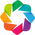

In [21]:
import holoviews as hv
hv.extension('bokeh', inline=False)

In [22]:
df_nb2 = df_nb.select(
    pl.col('neighborhood'),
    pl.col('borough'),
    pl.col('coordinates').list.eval(pl.element().list.get(0)).alias('lng'),
    pl.col('coordinates').list.eval(pl.element().list.get(1)).alias('lat'),
)

hv.Polygons(df_nb2.to_dicts(), kdims=['lng', 'lat'], vdims=['borough']).opts(cmap='tab10', data_aspect=1)

:Polygons   [lng,lat]   (borough)

## バイナリファイル

データフレーム操作を効率的に行うために、Polarsはさまざまなバイナリファイルフォーマットをサポートしています。特に、`ipc`（Inter-Process Communication）と`parquet`は、データの保存や転送に適したフォーマットです。

1. **IPC（Inter-Process Communication）**:
   - IPCフォーマットは、プロセス間での高速なデータ交換を目的としたバイナリ形式です。
   - Polarsでは、データフレームを効率的に保存および読み込むために使用され、特に同一のメモリ空間内で異なるプロセスがデータをやり取りする際に便利です。
   - 高速なシリアル化とデシリアル化が可能で、大きなデータセットの転送に最適です。

2. **Parquet**:
   - Parquetは、列指向のデータフォーマットで、大規模なデータを効率的に保存できるように設計されています。
   - 特に圧縮効率が高く、読み込み時には必要な列だけを効率的に取得できるため、ストレージとI/Oパフォーマンスを最適化できます。
   - 分散処理環境（例: Apache Spark）でよく使用される形式で、データ分析やETLパイプラインで広く利用されています。

どちらのフォーマットも、Polarsで高速なデータ処理を行う際に重要な役割を果たします。`ipc`は主にプロセス間通信で使用され、`parquet`はストレージと分析の効率化に優れています。

`ipc`と`parquet`フォーマットに対して、`DataFrame`データの読み込みと書き出しには`read_*()`と`write_*()`を使用します。一方、`LazyFrame`データの操作には`scan_*()`と`sink_*()`を使用します。それぞれの関数とメソッドについて以下に説明します。

- **`read_ipc()` と `read_parquet()` 関数**: バイナリファイルからデータを読み込み、`DataFrame`オブジェクトを取得します。
- **`DataFrame` の `write_ipc()` と `write_parquet()` メソッド**: `DataFrame`オブジェクトをバイナリファイルに書き出します。
- **`scan_ipc()` と `scan_parquet()` 関数**: バイナリファイルからデータを遅延評価形式で読み込み、`LazyFrame`オブジェクトを取得します。
- **`LazyFrame` の `sink_ipc()` と `sink_parquet()` メソッド**: `LazyFrame`オブジェクトをバイナリファイルストリームに書き出します。

既にメモリ上にデータがある`DataFrame`のデータをファイルに保存する場合は`write_*()`メソッドを使いますが、遅延評価を使用する`LazyFrame`のデータをファイルに書き出す場合は、`sink_*()`メソッドを使用します。このメソッドは一度にすべてのデータを処理するのではなく、チャンク単位でデータを処理するため、データのサイズがメモリより大きくても問題なく処理できます。

次のコードは、`scan_csv()`関数と`sink_ipc()`メソッドを使って、複数のCSVファイルを一つのIPCファイルに変換する処理です。これにより、大量のCSVデータをメモリに負荷をかけることなく効率的にIPCフォーマットに変換でき、後で高速に読み込むことが可能になります。

In [5]:
df_stock = pl.scan_csv('data/stock/**/*.csv', try_parse_dates=True)
df_stock.sink_ipc('data/stock.arrow')

In [33]:
df_stock = pl.read_ipc('data/stock.arrow')
df_stock

symbol,date,open,high,low,close,adj close,volume
str,date,f64,f64,f64,f64,f64,i64
"""ASML""",1999-01-04,11.765625,12.28125,11.765625,12.140625,7.522523,1801867
"""ASML""",1999-01-05,11.859375,14.25,11.71875,13.96875,8.655257,8241600
"""ASML""",1999-01-06,14.25,17.601563,14.203125,16.875,10.456018,16400267
"""ASML""",1999-01-07,14.742188,17.8125,14.53125,16.851563,10.441495,17722133
"""ASML""",1999-01-08,16.078125,16.289063,15.023438,15.796875,9.787995,10696000
…,…,…,…,…,…,…,…
"""TSM""",2023-06-26,102.019997,103.040001,100.089996,100.110001,99.125954,8560000
"""TSM""",2023-06-27,101.150002,102.790001,100.019997,102.080002,101.076591,9732000
"""TSM""",2023-06-28,100.5,101.879997,100.220001,100.919998,99.927986,8160900


上記の関数では、1つのデータフレームが1つのファイルに対応する形で処理されますが、`write_ipc_stream()`と`read_ipc_stream()`を使用することで、複数のデータフレームを順番に1つのファイルに書き出し、またそれを読み込むことができます。次のコードは、バイナリファイル`f`に2つのデータフレームを書き出す例です。

In [45]:
df1 = pl.DataFrame({"a":[1, 2, 3], "b":["xx", "yyy", "zzzz"]})
df2 = pl.DataFrame({"x":[3.0, 4.0, 6.0, 7.0], "y":[1.0, 2.0, 3.0, 4.0], "z":[0.0, 0.1, 0.2, 0.3]})

with open('data/stream_test.arrow', 'wb') as f:
    df1.write_ipc_stream(f)
    df2.write_ipc_stream(f)

次のコードで、バイナリファイルから順番にデータフレームを読み込むことができます。

```{note}
Polars 1.20.0までのバージョンでは、デフォルト値`use_pyarrow=False`を使用した場合、このコードは正しく動作しません。`use_pyarrow=True`を指定する必要があります。
```

In [47]:
with open('data/stream_test.arrow', 'rb') as f:
    df1_r = pl.read_ipc_stream(f, use_pyarrow=True)
    df2_r = pl.read_ipc_stream(f, use_pyarrow=True)

print(df1.equals(df1_r), df2.equals(df2_r))

True True
